
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet A2021 : Prédire les maladies cardiaques

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/3a185493d8bb48d8961ad50e465bed4f

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Il faudra que vous trouviez un moyen de traiter les données manquantes. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est appropriée.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [65]:
using CSV, DataFrames, Gadfly, GLM, Statistics
include("Math.jl")

plot_histogram_with_density

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [62]:
data = CSV.read("train.csv", DataFrame);

Tout d'abord, pour faire l'analyse des données rapidement, il est important de ne pas avoir de données manquantes. Cependant, on ne peut pas enlever tous les patients possédant des données manquantes, car ils représentent une trop grande proportion des données et cela pourrait affecter la tendance montrée par les graphiques. C'est pourquoi les données manquantes vont être remplacées par la moyenne des données de la colonne. 

In [63]:
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

#### 1.1 Informations sur les données

La première étape effectuée fût l'étude du contexte énoncé et des différentes variables mises à notre disposition. Nous avons ainsi effectué une recherche rapide sur la définition des différents termes médicaux. De plus, nous nous sommes renseignés sur quels facteurs pouvaient guider notre analyse des données. Il est important de mentionner que ces recherches n'ont servi que de guide. Pour poser une relation entre les maladies cardiovasculaires et les différents paramètres, ce sont les données à notre disposition qui ont été utilisées.

**Age** : âge du patient (années) </br>

**Sex** : le sexe du patient (M pour homme et F pour femme) </br>

**ChestPainType** : </br>
    TA: Angine de poitrine typique (survient dans des situations où le cœur doit fournir un effort supplémentaire, mais ne parvient pas à recevoir suffisamment d’oxygène en raison du rétrécissement d’une artère), </br>
    ATA: Angine de poitrine atypique (Lorsque l'angine est atypique, elle peut être de durée prolongée. Habituellement, une angine instable ou atypique peut être annonciatrice d'une crise cardiaque), </br>
    NAP: Douleur autre que l'angine, </br>
    ASY: Asymptomatique (aucune douleur) </br>

[Source](https://www.icm-mhi.org/fr/soins-et-services/maladies-cardiovasculaires/angine-de-poitrine)

**RestingBP** : tension artérielle au repos (en mm Hg)

On a ici les tensions systoliques qui est la force exercée lorsque le coeur se contracte et expulse le sang. </br>

Risque faible: 120 </br>
Risque moyen: 121-134 </br>
Risque élevé: 135+ </br>

[Source](https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/hypertension-arterielle)

**Cholesterol** : taux de cholesterol (en mmoles/dl)

Le cholestérol est un lipide qui est produit naturellement par le corps, mais dont la quantité peut augmenter en fonction de notre régime alimentaire. </br>
[Source](https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/taux-eleve-de-cholesterol)

**FastingBS** : glycémie à jeun (1 si FastingBS > 120 mg/dl, 0 sinon)

Hyperglycémie modérée (0) ou diabète (1). </br>
[Source](https://sante.journaldesfemmes.fr/fiches-anatomie-et-examens/2423998-glycemie-a-jeun-taux-normal-definition-elevee-basse-comment-baisser/)

**RestingECG** : électrocardiogramme au repos (Normal : normal ; ST : anomalie ST-T détectée ; LVH : hypertrophie du ventricule gauche)

Hypertrophie: Accroissement de la taille du coeur avec les parois du coeur qui s'épaississent. Peut se produire lorsque le coeur subit une charge de travail élevée pendant de longues périodes de temps. </br>
Ventricule gauche: épaissement du muscle de la cavité inférieure gauche du coeur. </br>

[Source](https://www.coeuretavc.ca/maladies-du-coeur/problemes-de-sante/hypertrophie-du-coeur)

**MaxHR** : rythme cardiaque maximum (battements par minutes)

**ExerciseAngina** : angine causée par l'exercice (Y: oui ; N: non)

**Oldpeak** : mesure sur l'électrocardiogramme (https://en.wikipedia.org/wiki/ST_depression)

**ST_Slope** : la pente sur l'électrocardiogramme (Up: croissante ; Flat : constante ; Down : décroissante)

Up: Peut etre mauvais
Flat: Bon
Down: Peut etre mauvais

## 2. Analyse exploratoire sommaire

### 2.1 Analyse des différents paramètres en fonction de la variable d'intérêt (HeartDisease)

Pour savoir si certains paramètres suivent des distributions différentes en fonction de la variable d'intérêt (HeartDisease), nous avons généré des histogrammes pour chaque variable dans le cas des patients malades et des patients sains. Cela peut être utile pour déterminer si un mélange de loi peut être utilisé pour certaines variables ou pas.

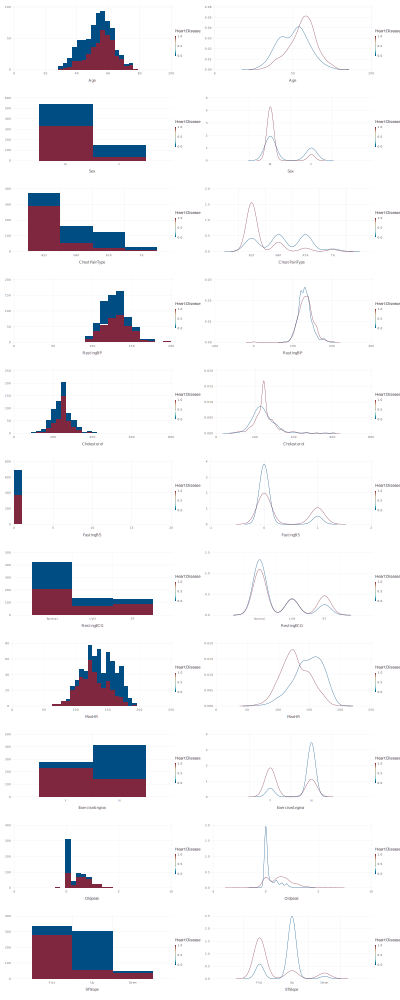

In [108]:
graphs = Plot[]

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.histogram(bincount=20)))
end

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.density()))
end

Gadfly.set_default_plot_size(40cm, 100cm)
Gadfly.gridstack(reshape(graphs, 11, 2))

In [ ]:
# Affichage des rythmes cardiques maximum en fonction de la classe

df = select(data, :MaxHR, :HeartDisease)

df.HeartDisease = string.(df.HeartDisease)

plot(df, x=:HeartDisease, y=:MaxHR, Geom.boxplot)

In [ ]:


## 3. Ajustement d'un modèle de régression logistique
M = glm(@formula(HeartDisease ~ MaxHR), data, Bernoulli(), LogitLink())

## 4. Prédiction des surverses pour les jours de l'ensemble de test
On utilise le modèle simple de la section précédente pour estimer la probabilité que le patient souffre d'une maladie cardiovasculaire.

#### 4.1 Chargement des données de l'ensemble de test

In [ ]:
test = CSV.read("test.csv", DataFrame);

#### 4.2 Prédiction pour chacun des patients de l'ensemble de test

On prédit que le patient souffre d'une maladie cardiovasculaire si la probabilité est supérieure à 50%.

In [ ]:
θ̂ = predict(M, test)

ŷ = Int64[]

for θ̂ᵢ in θ̂
    if θ̂ᵢ >= .5
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end


#### 3.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (ID) et d'une colonne des diagnostics prédits.

In [ ]:
prediction = DataFrame(ID = test.ID, Prediction = ŷ)

CSV.write("benchmark_predictions.csv", prediction)